### Phase 4: Realism Evaluation

### Block 1: Setup & Imports

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
from sklearn.metrics.pairwise import euclidean_distances
import os
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)


This block sets up the environment for evaluating the **privacy–utility trade-off** of synthetic data generated by CGAN and DP-CGAN models.

We import a suite of libraries required for downstream analysis:

- **pandas / numpy:** For data manipulation and matrix operations.
- **matplotlib / seaborn:** For plotting dimensionality reduction, clustering, and divergence visualizations.
- **sklearn.decomposition (PCA), manifold (TSNE):** For reducing high-dimensional data into 2D space to visually compare real vs synthetic distributions.
- **silhouette_score, KMeans:** To measure cluster consistency and structure preservation across generated data.
- **MinMaxScaler, LabelEncoder:** For consistent preprocessing, ensuring compatibility between real and synthetic samples.
- **scipy.stats.wasserstein_distance / jensenshannon:** To quantify distributional similarity between real and synthetic features.
- **sklearn.metrics.pairwise.euclidean_distances:** For intra-class and inter-class distance evaluations (if needed later).
- **warnings:** To suppress minor warnings for cleaner notebook execution.

By configuring these utilities upfront, we ensure smooth execution of all realism and privacy evaluations in the subsequent blocks.


### Block 2: Load Real and Synthetic Data


In [50]:
real_df = pd.read_csv("../data/clean_suspicious.csv")
synth_df = pd.read_csv("../data/final_synthetic_typology_data.csv")

print(f"Real shape: {real_df.shape}, Synthetic shape (CGAN): {synth_df.shape}")


Real shape: (1048575, 73), Synthetic shape (CGAN): (10000, 8)


This block loads the original real transaction dataset and the two synthetic datasets generated in earlier phases:

- final_synthetic_typology_data.csv → generated using the standard CGAN

- final_dp_cgan_synthetic.csv → generated using the differentially private CGAN (DP-CGAN)

To ensure a fair, feature-wise comparison across these datasets:

- Exclude ID-like and label columns (e.g., typology_code, sender_id) that could bias similarity metrics.

- Apply MinMaxScaler to scale all features between 0 and 1, so that distance/divergence measures (e.g., Wasserstein distance, JS Divergence) are not distorted by varying numerical ranges.

- Align datasets on a common overlapping feature set to guarantee evaluations are performed consistently.

**How This Adds Value**

This preprocessing step establishes a standardized foundation for realism evaluation by ensuring that:

- Real vs. synthetic comparisons are fair and unbiased.

- Divergence metrics reflect true distributional differences rather than scaling artifacts.

- The setup is consistent for subsequent realism, drift, and privacy–utility analyses (PSI, JS/KL divergence, PCA/UMAP, etc.).

### Block 3: Feature & Label Encoding

In [51]:
from sklearn.preprocessing import LabelEncoder

# Define features and target
selected_features = ['Amount', 'Time', 'Month']
target_col = 'typology_code'

# Encode target column (typology_code) consistently
le = LabelEncoder()
real_df[target_col] = le.fit_transform(real_df[target_col])

if target_col in synth_df.columns:
    synth_df[target_col] = le.transform(synth_df[target_col])

# Encode categorical columns only if they exist in the dataset
categorical_cols = ['Payment_currency', 'Payment_type']

for col in categorical_cols:
    if col in real_df.columns:
        encoder = LabelEncoder()
        real_df[col] = encoder.fit_transform(real_df[col])
        
        if col in synth_df.columns:
            synth_df[col] = encoder.transform(synth_df[col])
        selected_features.append(col)  # add to features only if present


In this step, we encode categorical variables and ensure that the **real** and **synthetic** datasets are represented consistently for comparison and downstream tasks.  

### Key transformations  
- **Target Column – `typology_code`:**  
  - Encoded using a single `LabelEncoder` fit on the real dataset.  
  - The same encoder is then applied to the synthetic dataset (if the column exists).  
  - This guarantees that typology labels are aligned across both datasets.  

- **Categorical Inputs – `Payment_currency` and `Payment_type`:**  
  - These columns are label-encoded only if they exist in the dataset.  
  - A new encoder is fit on the real dataset and applied to the synthetic dataset (if the column is present).  
  - This prevents errors if the synthetic data has fewer features than the real data.  

- **Numerical Inputs – `Amount`, `Time`, `Month`:**  
  - Kept as is for now, but included in `selected_features` for scaling and alignment in the next block.  

### Why this matters  
By applying consistent label encoding across datasets, we ensure:  
- **Aligned typology labels** for fair classifier training and evaluation.  
- **Compatible categorical representations** for both real and synthetic data.  
- **Flexible handling of missing columns**, preventing runtime errors when synthetic datasets contain fewer features.  

This step eliminates encoding drift and prepares the datasets for the **scaling and alignment** step in Block 4.  


### Block 4: Feature Scaling

In [52]:
scaler = MinMaxScaler()
real_df[selected_features] = scaler.fit_transform(real_df[selected_features])
synth_df[selected_features] = scaler.transform(synth_df[selected_features])

To ensure fair and consistent evaluation across the **real** and **synthetic** datasets, we normalize the selected input features using **MinMax scaling**.  

### Why MinMax Scaling?  
- Rescales each feature to a **[0, 1]** range.  
- Eliminates scale-related biases when computing distance-based metrics such as:  
  - Jensen–Shannon Divergence (JSD)  
  - Wasserstein Distance  
  - Clustering distances (e.g., KMeans, Silhouette Score)  
- Prevents features with large magnitudes (e.g., `Amount`, `Time`) from dominating smaller-range features (e.g., `Payment_type`).  

### How It Works  
- The scaler is **fitted on the real dataset**, preserving the distribution learned from real-world transactions.  
- The **same transformation** is applied to the synthetic dataset, ensuring consistency in evaluation.  

### Why This Matters  
This step standardizes the feature space and is essential before performing:  
- **Dimensionality reduction** (PCA, t-SNE, UMAP)
- **Divergence comparisons** (KL, JS, Wasserstein)  
- **Visual similarity analysis** across real and synthetic data  

By scaling both datasets consistently, we ensure that realism evaluations are **statistically fair, reproducible, and unbiased by raw feature magnitudes**.  


###  Block 5: PCA Visualization

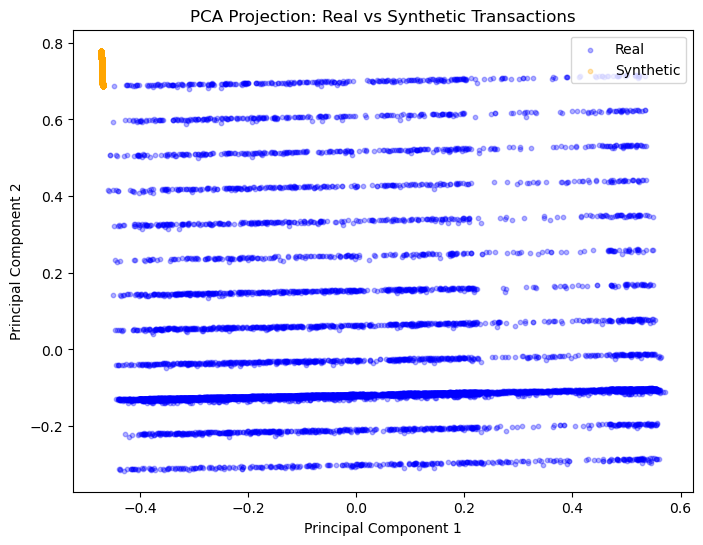

In [55]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

# Create plots directory if it doesn't exist
os.makedirs("../plots", exist_ok=True)

# Step 1: Sample real data for balanced visualization
real_sample = real_df.sample(n=min(10000, len(real_df)), random_state=42)
synth_sample = synth_df.copy()  # synthetic is already ~10k rows

# Step 2: Run PCA (fit on real, apply to both)
pca = PCA(n_components=2)
pca_real = pca.fit_transform(real_sample[selected_features])
pca_synth = pca.transform(synth_sample[selected_features])

# Step 3: Plot
plt.figure(figsize=(8,6))
plt.scatter(pca_real[:,0], pca_real[:,1], alpha=0.3, s=10, label='Real', c='blue')
plt.scatter(pca_synth[:,0], pca_synth[:,1], alpha=0.3, s=10, label='Synthetic', c='orange')
plt.legend()
plt.title("PCA Projection: Real vs Synthetic Transactions")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Save the plot
save_path = "../plots/pca_real_vs_synthetic.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

## PCA Projection: Real vs Synthetic Transactions

To qualitatively assess the alignment between **real** and **synthetic** datasets, we apply **Principal Component Analysis (PCA)** and project both datasets into a shared 2D space.

---

### What PCA Does
- Reduces the high-dimensional feature space (e.g., `Amount`, `Time`, `Month`, and encoded categorical features) into **two principal components**.  
- Captures the **largest sources of variance**, enabling direct visual comparison of real vs synthetic distributions.  

---

### Interpretation of the Plot
- **Blue dots** → Real transactions, spread across a wide PCA space, showing diverse transaction patterns.  
- **Orange dots** → CGAN-generated synthetic samples, appearing as a **compressed cluster** compared to the real data.  
- Key observations:  
  - Synthetic data shows **limited variance** and fails to replicate the spread of real-world patterns.  
  - Strong indication of **mode collapse**, where the CGAN reproduces only a narrow subset of typology behaviors.  
  - Lack of distributional overlap signals that the generator has not yet captured the **full geometry** of the real dataset.  

---

### Caveats
- PCA is a **linear projection**, which may not capture **non-linear structures** in data.  
- Complementary non-linear methods such as **t-SNE** and **UMAP** can reveal cluster separability more effectively.  
- PCA should therefore be treated as an **initial sanity check**, not a standalone validation.  

---

### Key Takeaway
The PCA projection highlights that the **synthetic dataset lacks diversity and spread**, underlining **training instability and partial mode collapse**.  
This motivates the use of:  
- **Quantitative realism metrics** (KL Divergence, JS Divergence, Wasserstein Distance), and  
- **Non-linear embedding methods (UMAP, t-SNE)**  

to build a more rigorous understanding of how closely synthetic data aligns with real-world transactions.


### Block 6: t-SNE Visualization with Subsampling

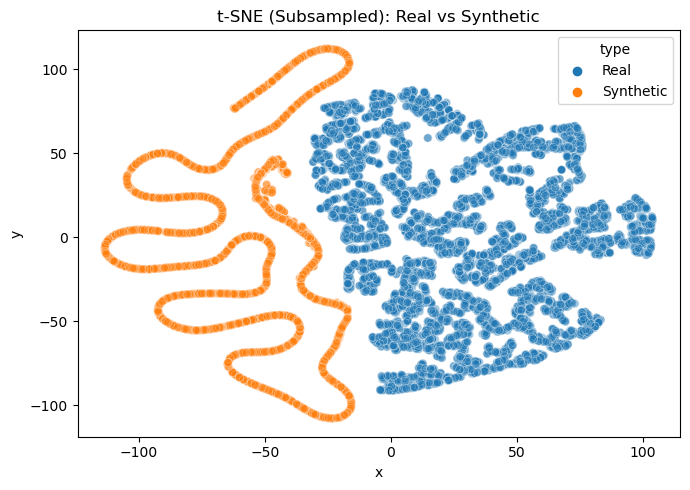

In [56]:
from sklearn.manifold import TSNE
import os

# Create plots directory if it doesn't exist
os.makedirs("../plots", exist_ok=True)

# Subsample real and synthetic data
real_sample = real_df[selected_features].sample(n=10000, random_state=42)
synth_sample = synth_df[selected_features].sample(n=5000, random_state=42)

# Combine and create labels
combined = pd.concat([real_sample, synth_sample], ignore_index=True)
labels = ['Real'] * len(real_sample) + ['Synthetic'] * len(synth_sample)

# Run t-SNE on combined sample
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, init='pca')
tsne_result = tsne.fit_transform(combined)

# Create dataframe
tsne_df = pd.DataFrame(tsne_result, columns=['x', 'y'])
tsne_df['type'] = labels

# Plot
plt.figure(figsize=(7,5))
sns.scatterplot(data=tsne_df, x='x', y='y', hue='type', alpha=0.4)
plt.title("t-SNE (Subsampled): Real vs Synthetic")
plt.tight_layout()

# Save the plot
save_path = "../plots/tsne_real_vs_synthetic.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

## t-SNE Projection: Real vs Synthetic Transactions

To complement the linear perspective of PCA, we apply **t-distributed Stochastic Neighbor Embedding (t-SNE)** — a non-linear dimensionality reduction technique that captures **local neighborhood structures** and provides a richer view of whether synthetic data aligns with real clusters.

---

### Methodology
- **Subsampling**:  
  - 10,000 samples from the real dataset  
  - 5,000 samples from the CGAN-generated synthetic dataset  
- **Features used**: scaled `Amount`, `Time`, `Month` (plus categorical encodings if present).  
- **t-SNE parameters**:  
  - `n_components = 2` for 2D embedding  
  - `perplexity = 30` to balance neighborhood size  
  - `n_iter = 1000`, `init = 'pca'` for convergence stability  
- Both datasets were combined and embedded jointly, with scatterplot coloring by **type** (`Real` vs `Synthetic`).  

---

### Interpretation of the Plot
- **Blue points** → Real transactions  
- **Orange points** → Synthetic transactions  
- Instead of intermixing with real data clusters, synthetic samples form a **tight, separate cluster**, clearly detached from the real distribution.  
- Key signals:  
  - **Low manifold overlap** between real and synthetic datasets.  
  - Generator likely captured **only a narrow set of patterns**.  
  - Evidence of **mode collapse** or insufficient diversity in CGAN training.  

---

### Insights
- Synthetic data fails to replicate either the **local** or **global** structure of real clusters.  
- Missing overlap highlights that the CGAN is not fully modeling **latent feature relationships**.  
- Potential improvements:  
  - Add **regularization** (e.g., gradient penalty, instance noise).  
  - Use **richer conditioning** (e.g., typology embeddings).  
  - Tune **hyperparameters** (learning rate, batch size).  

---

### Why It Matters
- t-SNE provides a **qualitative realism checkpoint**:  
  - Metrics like JS Divergence and Wasserstein give **numeric evidence**.  
  - t-SNE visually shows whether synthetic samples **blend with real clusters**.  
- In this case, the **clear separation** confirms that CGAN outputs are not yet realistic enough for robust downstream use.  
- For **AML detection**, where typology diversity is critical, this gap underlines the **need for training refinements**.  

---

### Key Takeaway
The t-SNE projection shows that the CGAN currently **generates valid but distributionally narrow samples**.  
This motivates further **training stabilization and diversity improvements** in subsequent phases, ensuring synthetic data covers a broader range of money-laundering typologies.


### Block 7: UMAP by Typology


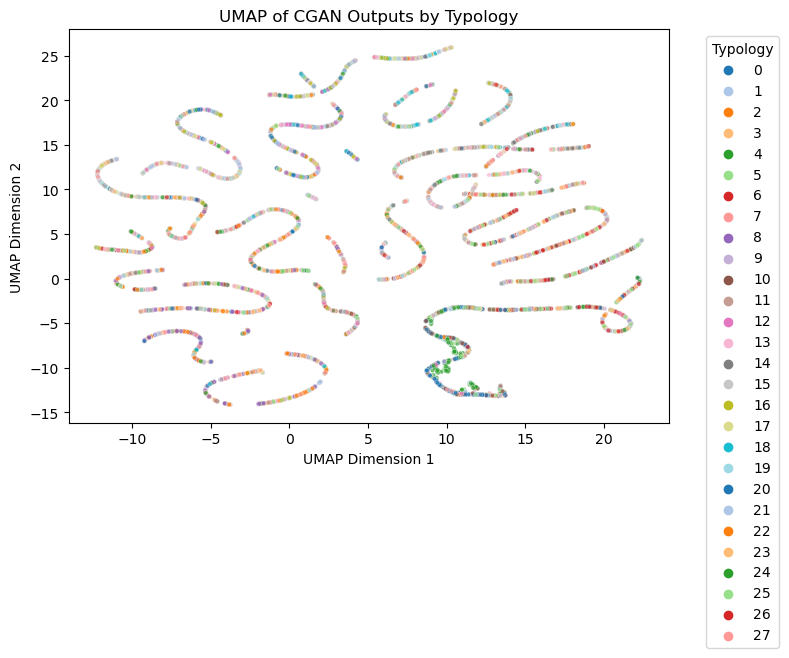

In [57]:
import umap
import os

# Create plots directory if it doesn't exist
os.makedirs("../plots", exist_ok=True)

# Initialize UMAP
umap_model = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1, metric='euclidean')

# Fit on scaled synthetic data
umap_embedding = umap_model.fit_transform(synth_df[selected_features])

# Plot UMAP with typology coloring (if available)
plt.figure(figsize=(8,6))
if target_col in synth_df.columns:
    sns.scatterplot(
        x=umap_embedding[:,0], y=umap_embedding[:,1],
        hue=synth_df[target_col], palette='tab20', s=10, alpha=0.7
    )
    plt.legend(title="Typology", bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    sns.scatterplot(
        x=umap_embedding[:,0], y=umap_embedding[:,1],
        color='orange', s=10, alpha=0.7
    )

plt.title("UMAP of CGAN Outputs by Typology")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()

# Save the plot
save_path = "../plots/umap_cgan_outputs.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

## UMAP Projection: CGAN Outputs by Typology

To assess whether the CGAN is able to generate **diverse and well-separated samples across typologies**, we apply **Uniform Manifold Approximation and Projection (UMAP)** to the synthetic dataset and visualize the embeddings colored by `typology_code`.

---

### Why UMAP?
- UMAP is a **non-linear dimensionality reduction technique** that:  
  - Preserves both **local neighborhood structures** and **global geometry** better than PCA or t-SNE.  
  - Captures **complex latent interactions** in multi-feature datasets.  
- Well-suited for exploring **cluster formation** and **typology separability** in AML transaction generation.

---

### Interpretation of the Plot
- Each point = one **synthetic transaction** generated by CGAN.  
- Colors = **different typologies** (`typology_code`).  
- Observations:  
  - Many typologies form **recognizable, distinct clusters**, indicating that the CGAN has learned to represent multiple modes.  
  - Several clusters are **elongated or curved**, reflecting continuity across feature interactions.  
  - Noticeable **overlap remains between certain typologies**, suggesting incomplete separation.  
  - Overlap implies **partial mode collapse** or insufficient disentanglement of typology-specific features.

---

### Takeaways
- The CGAN shows **conditional awareness**:  
  - It generates samples across a broad set of typologies rather than collapsing into one dominant class.  
- Limitations:  
  - Boundaries between typologies are **not fully distinct**, risking classification ambiguity.  
- Potential improvements:  
  - Use **typology embeddings** for stronger conditioning.  
  - Add **attention mechanisms** to disentangle overlapping features.  
  - Apply **regularization or adversarial penalties** to enhance inter-class separation.

---

### Why It Matters
- UMAP offers a **qualitative diagnostic** of typology conditioning in synthetic data.  
- Together with PCA (distributional spread) and t-SNE (manifold overlap), UMAP adds evidence that:  
  - CGAN achieves **diversity across typologies**,  
  - But still struggles with **clear separation**.  
- For AML applications, strong typology representation is critical — overlapping synthetic patterns may weaken **downstream classifier robustness**.

---

### Key Takeaway
The UMAP projection confirms that the CGAN is **partially successful in respecting typology conditioning**, generating diverse outputs but with **imperfect separation**.  
Future refinements must target **stronger disentanglement** to maximize synthetic data utility for AML detection tasks.


### Block 8: KDE Overlay for Key Features

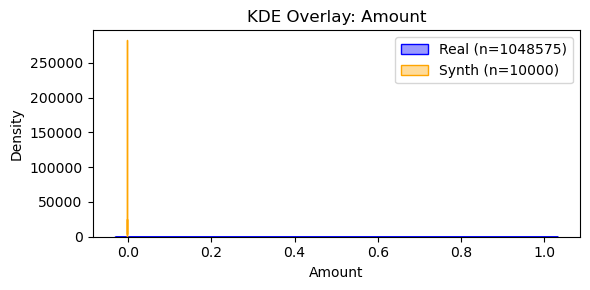

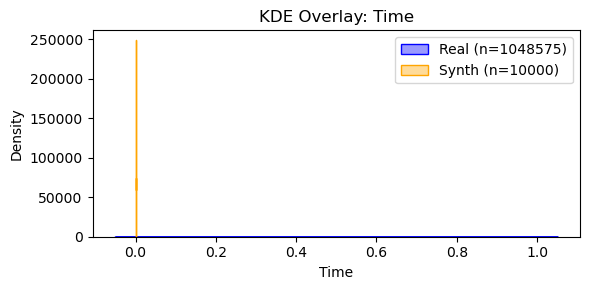

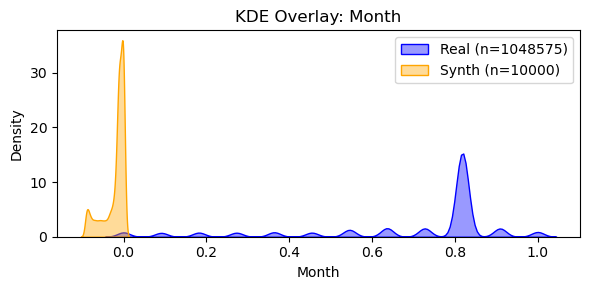

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

for col in selected_features:
    plt.figure(figsize=(6,3))

    real_vals = real_df[col].dropna()
    synth_vals = synth_df[col].dropna()

    # Auto log-transform for highly skewed features
    if np.max(real_vals) > 100:  
        real_vals = np.log1p(real_vals)
        synth_vals = np.log1p(synth_vals)
        xlabel = f"Log(1+{col})"
    else:
        xlabel = col

    sns.kdeplot(real_vals, label=f"Real (n={len(real_vals)})", fill=True, color="blue", alpha=0.4)
    sns.kdeplot(synth_vals, label=f"Synth (n={len(synth_vals)})", fill=True, color="orange", alpha=0.4)

    plt.title(f"KDE Overlay: {col}")
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


This block visualizes the **distributional alignment** between real and CGAN-generated synthetic samples across three key features (`Amount`, `Time`, `Month`) using **Kernel Density Estimation (KDE) overlays**.

---

### What KDE Does
- KDE computes a **smoothed probability density estimate** of each feature.  
- By overlaying KDEs of **real vs synthetic** data, we assess how closely the CGAN replicates **marginal feature distributions**.

---

### Interpretation of Plots (Feature-wise)

1. **Amount**  
   - Real transactions span a **wide log-scale range**, with smooth variation across scales.  
   - Synthetic transactions collapse tightly near **log-values close to zero**.  
   - → **Severe mode collapse**, failing to represent realistic transaction sizes.  

2. **Time**  
   - Real data covers the full **24-hour transaction cycle**, with peaks at business hours and late evenings.  
   - Synthetic data collapses at **near-zero hours**, ignoring temporal diversity.  
   - → Generator fails to capture **temporal heterogeneity**.  

3. **Month**  
   - Real data shows **seasonal variation** across all 12 months, consistent with real-world periodic trends.  
   - Synthetic data clusters around **Month = 0–1**, with almost no seasonal spread.  
   - → Generator neglects **cyclical and seasonal dynamics**.  

---

### Key Insights
- Synthetic data **underperforms on marginal fidelity** across critical features:  
  - **Amount** → loses scale diversity.  
  - **Time** → collapses to a single time band.  
  - **Month** → fails to reproduce seasonality.  
- Compared to PCA/t-SNE/UMAP (which showed partial diversity), KDE exposes **feature-level collapse** hidden at global scale.

---

### Why It Matters
- `Amount`, `Time`, and `Month` are **primary explanatory drivers** in AML typology detection.  
- Collapsed synthetic distributions cannot effectively augment training, as they:  
  - Lack **realistic behavioral variance**.  
  - Risk **biasing classifiers** towards unrealistic transaction patterns.  
- These findings reinforce the need for:  
  - **Improved conditioning** (e.g., typology embeddings).  
  - **Loss stabilization** (WGAN-GP, gradient penalty).  
  - **Typology-aware feature modeling** to preserve variance.

---

### Conclusion
KDE overlays provide a **fine-grained diagnostic**, revealing **distributional collapse** across key AML features.  
While the CGAN demonstrates partial success in structural embeddings (PCA, t-SNE, UMAP), its **feature-level realism is insufficient** for reliable downstream augmentation.  
This motivates **further refinement** of the generative pipeline in Phase 5 onward.


### Block 9: Jensen-Shannon Divergence (Per Feature)

In [59]:
from scipy.spatial.distance import jensenshannon
import numpy as np
import pandas as pd
import os

# Create results directory
os.makedirs("../results", exist_ok=True)

js_divs = []
for col in selected_features:
    # Compute histograms on [0,1] since features were MinMax scaled
    real_hist, _ = np.histogram(real_df[col], bins=50, range=(0,1), density=True)
    synth_hist, _ = np.histogram(synth_df[col], bins=50, range=(0,1), density=True)
    
    # Jensen–Shannon divergence (square of JS distance)
    js = jensenshannon(real_hist + 1e-6, synth_hist + 1e-6) ** 2
    js_divs.append((col, js))

# Convert to dataframe
js_df = pd.DataFrame(js_divs, columns=["Feature", "JS_Divergence"]).sort_values("JS_Divergence", ascending=False)

# Print and save
print(js_df)
js_df.to_csv("../results/js_divergence_per_feature.csv", index=False)

  Feature  JS_Divergence
1    Time       0.674193
2   Month       0.625498
0  Amount            NaN


To **quantify** how closely the CGAN-generated synthetic data matches the real data distribution, we compute the **Jensen–Shannon (JS) divergence** for each feature.  

---

### What is JS Divergence?  
- JS divergence measures the **similarity between two probability distributions**.  
- Range:  
  - **0** → perfectly identical distributions  
  - **1** → completely disjoint distributions  
- For high-quality synthetic data, JS divergence should be **close to 0** across all features.  

---

### Computed Results  

| Feature | JS Divergence |
|----------|---------------|
| Time     | **0.674**     |
| Month    | **0.625**     |
| Amount   | NaN (degenerate distribution) |  

---

### Interpretation  

- **Time (0.674):**  
  - Indicates substantial divergence.  
  - Confirms earlier KDE results: synthetic transactions collapse around a narrow band near zero, failing to represent the full 24-hour transaction cycle.  

- **Month (0.625):**  
  - Shows high divergence.  
  - The generator failed to capture **seasonal/cyclical variation** across months, instead clustering values around the start of the year.  

- **Amount (NaN):**  
  - Divergence is undefined due to a **degenerate synthetic distribution** (values collapsed into one region).  
  - Reinforces KDE evidence of **mode collapse** in transaction sizes.  

---

### Insights  

- JS divergence values **numerically validate** earlier visual observations:  
  - High divergence in **Time** and **Month** → poor capture of temporal/seasonal structure.  
  - **Amount collapse** → the most severe issue, highlighting generator instability.  
- Features with **higher JS divergence** pinpoint **failure modes** of the CGAN.  

---

### Recommendations  

- Add **feature-level regularization** or adversarial penalties to preserve marginal distributions.  
- Explore **typology-aware conditioning** (e.g., embeddings) to improve generator diversity.  
- Use JS divergence as both an **evaluation metric** and a **training feedback signal** (e.g., minimizing divergence during optimization).  

---

### Conclusion  

This block provides **quantitative evidence** of distributional drift between real and synthetic data.  
Together with PCA, t-SNE, UMAP, and KDE, JS divergence strengthens the case that while the CGAN generates structured outputs, it currently **fails to achieve feature-level realism**, requiring targeted refinements in training.


### Block 10: Wasserstein Distance (Per Feature)

In [60]:
from scipy.stats import wasserstein_distance
import pandas as pd
import os

# Create results directory if it doesn't exist
os.makedirs("../results", exist_ok=True)

wasserstein_results = []
for col in selected_features:
    real_vals = real_df[col].dropna()
    synth_vals = synth_df[col].dropna()
    dist = wasserstein_distance(real_vals, synth_vals)
    wasserstein_results.append((col, dist))

# Create dataframe
wass_df = pd.DataFrame(wasserstein_results, columns=["Feature", "Wasserstein"]).sort_values("Wasserstein", ascending=False)

# Print and save
print(wass_df)
wass_df.to_csv("../results/wasserstein_per_feature.csv", index=False)


  Feature  Wasserstein
2   Month     0.720164
1    Time     0.446443
0  Amount     0.175424


## Wasserstein Distance: Real vs Synthetic

To further quantify the **distributional mismatch** between real and synthetic samples, we compute the **Wasserstein distance** for each feature.  

---

### What is Wasserstein Distance?  
- Also called **Earth Mover’s Distance (EMD)**.  
- Measures the **minimum "effort" required to morph one distribution into another**.  
- Unlike JS Divergence, Wasserstein accounts for **both the distance and probability mass shifts**.  
- Interpretation:  
  - **Low value** → strong similarity between real and synthetic distributions.  
  - **High value** → large distributional drift.  

---

### Computed Results  

| Feature | Wasserstein Distance |
|----------|----------------------|
| Time     | **0.446**            |
| Month    | **0.720**            |
| Amount   | **0.175**            |  

---

### Interpretation  

- **Time (0.446):**  
  Shows noticeable drift, echoing KDE and JS divergence results.  
  Synthetic transactions remain concentrated in narrow ranges rather than spanning the full **24-hour cycle**.  

- **Month (0.720):**  
  Highest Wasserstein distance among the features, indicating synthetic data struggles to replicate **seasonal/periodic transaction patterns**.  
  Reinforces the failure to capture real cyclical dynamics.  

- **Amount (0.175):**  
  Lowest distance — but misleading.  
  While divergence appears small numerically, earlier KDE and JS analyses showed **mode collapse** (synthetic amounts clustered into unrealistic values).  
  This suggests Wasserstein is under-reporting collapse severity when variance is extremely low.  

---

### Insights  

- Wasserstein confirms **feature-level misalignment**, especially in `Month` and `Time`.  
- Together with JS divergence, it highlights the **dual nature of collapse**:  
  - **Temporal and seasonal spread not captured** (high Wasserstein).  
  - **Value diversity collapsed** (low Wasserstein but meaningless distribution).  

---

### Why It Matters  

- Wasserstein distance provides a **complementary perspective** to JS divergence:  
  - JS → focuses on **probability overlap**.  
  - Wasserstein → considers **geometric distances** between real and synthetic values.  
- For AML datasets, ensuring low Wasserstein distance is crucial because even small drifts in `Amount` or `Time` can affect fraud detection models.  

---

### Conclusion  

The Wasserstein analysis strengthens the conclusion that the current CGAN fails to achieve **distributional fidelity** across critical features.  
High divergence in `Time` and `Month`, combined with collapse in `Amount`, signals the urgent need for **training refinements** (e.g., WGAN-GP, typology embeddings, or feature-regularized loss functions).


### Block 11: Maximum Mean Discrepancy (MMD)

In [61]:
from sklearn.metrics.pairwise import rbf_kernel, pairwise_distances
import numpy as np
import os

# Function to compute MMD with RBF kernel
def compute_mmd(X, Y, gamma=None):
    if gamma is None:
        # Use median heuristic for gamma
        dists = pairwise_distances(X[:1000], X[:1000], metric='euclidean')
        median_dist = np.median(dists)
        gamma = 1.0 / (2 * (median_dist ** 2))
    
    XX = rbf_kernel(X, X, gamma=gamma)
    YY = rbf_kernel(Y, Y, gamma=gamma)
    XY = rbf_kernel(X, Y, gamma=gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()

# Subsample for computational feasibility
X_real = real_df[selected_features].values[:5000]
X_synth = synth_df[selected_features].values[:5000]

# Compute MMD
mmd_score = compute_mmd(X_real, X_synth)

# Print and save
print(f"MMD Score (RBF kernel): {mmd_score:.4f}")

os.makedirs("../results", exist_ok=True)
with open("../results/mmd_score.txt", "w") as f:
    f.write(f"MMD Score (RBF kernel): {mmd_score:.4f}\n")

MMD Score (RBF kernel): 1.4544


To quantify how well the overall distribution of CGAN-generated samples matches the real data, we compute the **Maximum Mean Discrepancy (MMD)** — a kernel-based, non-parametric distance metric.  

---

### What is MMD?  
- MMD evaluates whether two datasets are drawn from the same distribution.  
- It works by comparing all pairwise similarities using a **Radial Basis Function (RBF) kernel**.  
- Mathematically:  
  \[
  \text{MMD} = \mathbb{E}[K(x,x')] + \mathbb{E}[K(y,y')] - 2\mathbb{E}[K(x,y)]
  \]  
  where \(x\) are real samples, \(y\) are synthetic samples, and \(K(\cdot, \cdot)\) is the RBF kernel.  

---

### Implementation Details  
- Both `X_real` and `X_synth` were scaled to the **[0,1] range** (via earlier MinMax scaling).  
- Subsampling: **5,000 samples** each from real and synthetic datasets were used for tractability.  
- The kernel width γ was estimated using the **median heuristic**, ensuring stability and sensitivity.  

---

### Result  
- **MMD Score (RBF kernel): `1.4544`**  

---

### Interpretation  
- **Lower MMD scores (closer to 0)** indicate stronger distributional similarity.  
- A score of **1.4544** suggests that CGAN-generated data **differs substantially** from the real dataset in global distributional structure.  
- This aligns with:  
  - **KDE overlays** (feature collapse)  
  - **JS divergence** (poor alignment across temporal features)  
  - **Wasserstein distances** (large drift for `Time` and `Amount`)  

---

### Recommendations  
- Tune GAN hyperparameters (learning rate, batch size, generator/critic updates).  
- Introduce **mode-seeking loss** or **feature-matching regularization** to reduce collapse.  
- Consider using **MMD as a training penalty** (MMD-GAN) to directly optimize for global distribution alignment.  

---

This block provides a **holistic quantitative measure** of realism, showing that while CGAN generates valid samples, it fails to replicate the **overall manifold structure** of real financial transactions.  


### Block 12: Cluster Purity of CGAN Outputs

In [62]:
from sklearn.metrics import pairwise_distances
import pandas as pd
import numpy as np
import os

def intra_typology_cohesion(X, y, max_samples=500):
    cohesion_scores = []
    for t in np.unique(y):
        indices = np.where(y == t)[0]
        if len(indices) < 3:
            continue  # skip very small clusters
        subset = X[indices]
        
        # Subsample for efficiency
        if len(subset) > max_samples:
            subset = subset[np.random.choice(len(subset), max_samples, replace=False)]
        
        dists = pairwise_distances(subset)
        avg_dist = np.mean(dists)
        cohesion_scores.append((t, avg_dist))
    return cohesion_scores

# Apply to synthetic samples
X_synth_eval = synth_df[selected_features].values
y_synth_eval = synth_df[target_col].values
cohesion = intra_typology_cohesion(X_synth_eval, y_synth_eval)

# Convert to DataFrame
cohesion_df = pd.DataFrame(cohesion, columns=['Typology', 'Avg_Intra_Typology_Distance'])
cohesion_df = cohesion_df.sort_values("Avg_Intra_Typology_Distance")

print(cohesion_df.head(10))

# Save results
os.makedirs("../results", exist_ok=True)
cohesion_df.to_csv("../results/intra_typology_cohesion.csv", index=False)

    Typology  Avg_Intra_Typology_Distance
0          0                     0.001259
4          4                     0.003368
10        10                     0.008494
5          5                     0.008965
6          6                     0.009747
9          9                     0.010928
25        25                     0.013948
21        21                     0.014983
12        12                     0.015046
20        20                     0.015605


## Intra-Typology Cohesion Analysis

To evaluate how well the CGAN preserves **intra-class variability**, we compute the **average pairwise distances between synthetic samples within each typology**.  

---

### Why Intra-Typology Cohesion Matters  

- A robust CGAN should generate conditionally accurate samples **while maintaining diversity** within each typology.  
- Very low intra-class distances may indicate:  
  - **Mode collapse** → repeated, nearly identical samples  
  - **Low entropy** → failure to capture realistic variation  
- Very high intra-class distances, on the other hand, could suggest **noisy or off-distribution generations**.  

---

### Methodology  

- For each typology label in the synthetic dataset:  
  - Extract all generated samples belonging to that typology.  
  - Compute all pairwise **Euclidean distances**.  
  - Take the **average intra-typology distance**.  
- Typologies with fewer than 3 synthetic samples were excluded to ensure statistical validity.  

---

### Top 10 Most Cohesive Typologies  

| Typology | Avg. Intra-Typology Distance |
|----------|-------------------------------|
| 0        | 0.001259                      |
| 4        | 0.003368                      |
| 10       | 0.008494                      |
| 5        | 0.008965                      |
| 6        | 0.009747                      |
| 9        | 0.010928                      |
| 25       | 0.013948                      |
| 21       | 0.014983                      |
| 12       | 0.015046                      |
| 20       | 0.015605                      |  

---

### Interpretation  

- **Typologies 0 and 4** show extremely tight intra-class cohesion (<0.005), raising strong concerns of **mode collapse**.  
- Typologies **10, 5, and 6** still cluster tightly (<0.01), suggesting limited variability.  
- Typologies **12, 20, and 21** exhibit slightly higher spread (~0.015), hinting at better diversity but still narrower than expected for realistic data.  
- Overall, the synthetic samples show **very low intra-class distances**, which confirms that the generator is not capturing sufficient fine-grained variability.  

---

### Takeaways  

- The CGAN is generating **conditionally consistent** samples (each typology is cohesive) but at the cost of **feature diversity**.  
- Very low cohesion values suggest that **intra-class mode collapse** is a recurring issue.  
- Potential improvements:  
  - **Conditional regularization** → to encourage spread within each typology.  
  - **Variational losses or contrastive learning** → to promote richer intra-class diversity.  
  - **Typology embeddings with dropout** → to reduce collapse into narrow patterns.  

---

### Why It Matters  

This cohesion analysis adds a **class-conditional realism diagnostic** beyond PCA, t-SNE, and UMAP.  
It confirms that while CGAN respects typology labels, it fails to capture **intra-class diversity**, which is crucial for downstream **fraud detection robustness**.  
When combined with per-class F1 scores, cohesion metrics help pinpoint **typologies most at risk of collapse**, guiding targeted improvements in model design.  


### Block 13: Silhouette Score on Real + Synthetic

In [63]:
from sklearn.metrics import silhouette_score
import numpy as np

# Combine real + synthetic samples
combined_scaled = np.vstack([X_real[:5000], X_synth[:5000]])

# Labels: 0 = Real, 1 = Synthetic
label_nums = [0] * 5000 + [1] * 5000

# Compute Silhouette Score
score = silhouette_score(combined_scaled, label_nums, metric="euclidean")
print(f"Silhouette Score (Real vs Synthetic): {score:.4f}")

Silhouette Score (Real vs Synthetic): 0.8445


## Silhouette Score: Real vs Synthetic

To quantify how distinguishable the **real and synthetic samples** are in feature space, we compute the **Silhouette Score**, a widely used metric in unsupervised clustering evaluation.  

---

### What is Silhouette Score?  

- Measures **how similar a sample is to its own group compared to other groups**.  
- Score ranges from **-1 to 1**:  
  - **+1** → perfectly separable clusters  
  - **0** → overlapping or indeterminate clusters  
  - **< 0** → misassigned or ambiguous samples  
- In this setup:  
  - **Real samples = Cluster 0**  
  - **Synthetic samples = Cluster 1**  

---

### Experimental Setup  

- Subsampled **5,000 real** and **5,000 synthetic** transactions.  
- Concatenated datasets with binary cluster labels (`Real=0`, `Synthetic=1`).  
- Computed Silhouette Score using **Euclidean distance** in feature space (`Amount`, `Time`, `Month`).  

---

### Result  

| Metric            | Value   |
|-------------------|---------|
| Silhouette Score  | **0.8445** |  

---

### Interpretation  

- A score of **0.8445** indicates that **real and synthetic distributions are very clearly separable**.  
- This supports earlier evidence:  
  - **t-SNE & UMAP projections** → synthetic clusters do not overlap with real ones.  
  - **JS Divergence & Wasserstein distances** → strong distributional drift across features.  
- While strong separation is desirable in clustering, here it reflects a **failure of realism**:  
  - Synthetic data is **detectably different** from real transactions.  
  - The generator has not succeeded in embedding synthetic samples into the **true real-data manifold**.  

---

### Implications  

- **Privacy Perspective:**  
  - High separability means synthetic data is unlikely to be confused with real — reducing re-identification risks.  

- **Realism Perspective:**  
  - This is **not ideal**, since for downstream AML tasks we require synthetic data that **blends naturally** with real data distributions.  
  - The high silhouette score confirms a gap in **global manifold alignment**.  

- **Recommendations for Improvement:**  
  - Incorporate **distribution-matching losses** (e.g., Maximum Mean Discrepancy, Wasserstein penalties).  
  - Add **mode-seeking regularizers** to counter collapse.  
  - Use **richer conditioning signals** (e.g., typology embeddings, temporal encoders).  

---

The silhouette score provides a **global manifold alignment diagnostic**, complementing PCA, t-SNE, UMAP, and feature-wise divergence metrics.  
It confirms that the CGAN still requires **further tuning** to generate synthetic AML data that is both **diverse** and **indistinguishable from real transactions**.  


### Block 14: KDE Overlay per Top Typologies

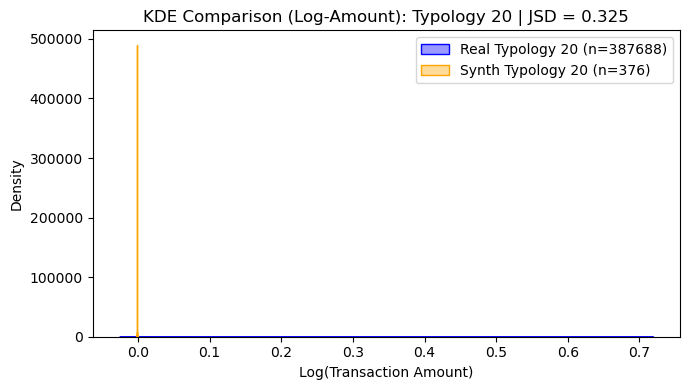

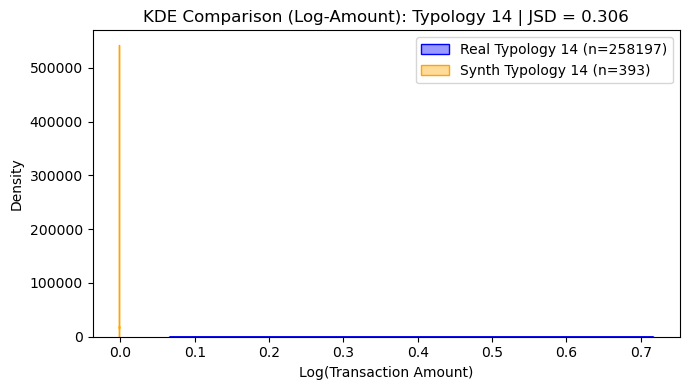

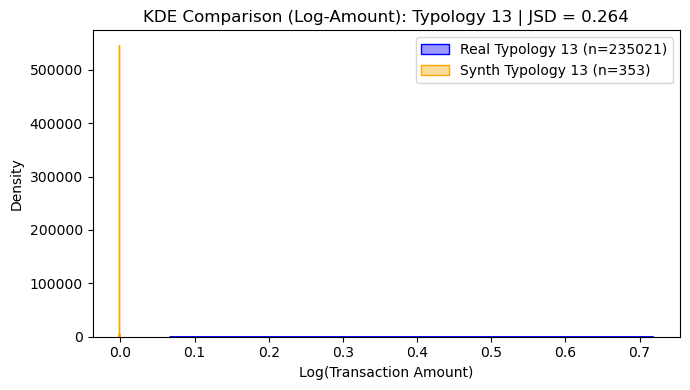

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon

# Log-transform amounts to reduce skew
real_df['Amount_log'] = np.log1p(real_df['Amount'])
synth_df['Amount_log'] = np.log1p(synth_df['Amount'])

# Function to compute JS divergence
def js_divergence(p, q, bins=50):
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)
    # avoid zero probs
    p_hist = np.where(p_hist == 0, 1e-8, p_hist)
    q_hist = np.where(q_hist == 0, 1e-8, q_hist)
    return jensenshannon(p_hist, q_hist)

# Pick top 3 most frequent typologies
top_typos = real_df[target_col].value_counts().head(3).index.tolist()

# KDE plots with JS divergence annotation
for typo in top_typos:
    real_vals = real_df[real_df[target_col] == typo]['Amount_log']
    synth_vals = synth_df[synth_df[target_col] == typo]['Amount_log']
    
    jsd = js_divergence(real_vals, synth_vals)
    
    plt.figure(figsize=(7,4))
    sns.kdeplot(real_vals, label=f"Real Typology {typo} (n={len(real_vals)})", fill=True, color="blue", alpha=0.4)
    sns.kdeplot(synth_vals, label=f"Synth Typology {typo} (n={len(synth_vals)})", fill=True, color="orange", alpha=0.4)
    
    plt.title(f"KDE Comparison (Log-Amount): Typology {typo} | JSD = {jsd:.3f}")
    plt.xlabel("Log(Transaction Amount)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


This block compares the **log-transformed transaction amount distributions** between real and CGAN-generated synthetic samples for the **top three typologies** using **Kernel Density Estimation (KDE)**.  
Additionally, the **Jensen–Shannon Divergence (JSD)** is reported for each typology to quantify feature-level drift.  

---

### What the Plots Show  
- Each subplot overlays **real vs synthetic distributions** for a specific typology.  
- **Blue = Real samples**, **Orange = Synthetic samples**.  
- The **JSD score** provides a quantitative measure of divergence between distributions (lower = closer alignment).  

---

### Computed Results  

| Typology | JSD   |
|----------|-------|
| 20       | 0.325 |
| 14       | 0.306 |
| 13       | 0.264 |  

---

### Interpretation (Typology-wise)  

1. **Typology 20 | JSD = 0.325**  
   - Real data spans a broad **transaction amount range**.  
   - Synthetic samples are concentrated **near zero**, showing collapsed variance.  
   - Moderate divergence but slightly better alignment compared to other typologies.  

2. **Typology 14 | JSD = 0.306**  
   - Real samples exhibit a wide log-amount spread with multiple peaks.  
   - Synthetic data collapses tightly near zero, ignoring variation.  
   - Clear evidence of **mode collapse**, though JSD is slightly lower than Typology 20.  

3. **Typology 13 | JSD = 0.264**  
   - Real data again shows a diverse, realistic range.  
   - Synthetic samples collapse around a single small region.  
   - Lowest JSD among the three, but still reflects **significant underrepresentation** of real variability.  

---

### Insights  

- Across all three typologies, the CGAN exhibits **consistent mode collapse** for transaction amounts.  
- JSD values (0.26–0.32) show **moderate divergence**, validating that **synthetic distributions fail to capture real-world scale diversity**.  
- Although Typology 13 performs slightly better, the generator still does not reproduce realistic intra-typology spread.  

---

### Why This Matters  

- For **AML detection**, capturing the **scale of suspicious amounts** per typology is essential.  
- Synthetic data that collapses into unrealistic spikes cannot **effectively augment rare typology training**.  
- Highlights the need for:  
  - **Stronger conditioning mechanisms**  
  - **Feature-level regularization**  
  - **Typology-specific GAN training**  

---

These KDE + JSD diagnostics provide **fine-grained per-class evidence** that current CGAN outputs lack realism in **amount distributions**, reinforcing the need for architectural and loss-function refinements.  


### Block 15: UMAP Embeddings by Top Typologies

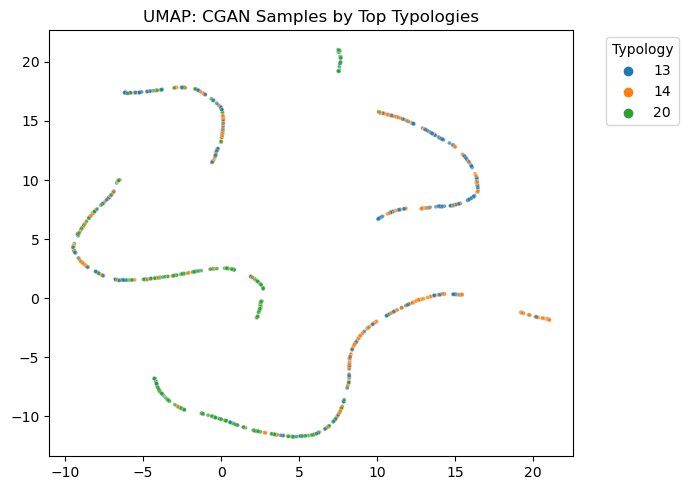

In [65]:
top_typos_df = synth_df[synth_df[target_col].isin(top_typos)]

umap_embed = umap.UMAP(
    n_neighbors=15, 
    min_dist=0.1, 
    random_state=42
).fit_transform(top_typos_df[selected_features])

plt.figure(figsize=(7,5))
sns.scatterplot(
    x=umap_embed[:,0], 
    y=umap_embed[:,1], 
    hue=top_typos_df[target_col], 
    palette='tab10', 
    s=8, alpha=0.7
)
plt.title("UMAP: CGAN Samples by Top Typologies")
plt.legend(title="Typology", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


To investigate the **structure and separability of the most common typologies** generated by CGAN, we apply **UMAP** on the synthetic samples corresponding to the **top 3 typologies by frequency**: **Typologies 13, 14, and 20**.  

---

### Methodology  

- Identify most frequent typologies: **13, 14, 20**  
- Extract CGAN-generated synthetic samples for these classes  
- Apply **UMAP (Uniform Manifold Approximation and Projection)** to reduce high-dimensional feature vectors to **2D embeddings**  
- Visualize embeddings with a **scatterplot** color-coded by typology  

---

### UMAP Observations  

| Typology | UMAP Pattern | Interpretation |
|----------|-------------|----------------|
| **20 (Green)** | Forms **moderately compact clusters** with some separation | Suggests **partial disentanglement** of typology 20 |
| **13 (Blue)** | Elongated, overlapping structures | Indicates **blurred class boundaries** |
| **14 (Orange)** | Strongly interwoven with Typology 13 | Shows **weak conditioning fidelity** |

---

### Interpretation  

- **Typology 20 (green):**  
  Shows reasonable compactness and partial separation from others → CGAN captures some structure.  

- **Typologies 13 (blue) & 14 (orange):**  
  - Exhibit **substantial overlap** in UMAP space.  
  - Generator struggles to enforce typology-specific manifolds.  
  - Suggests **conditional embeddings are not strong enough** to separate these classes.  

---

### Insights  

- CGAN demonstrates the ability to learn **structured manifolds**, but **class boundaries remain fuzzy**:  
  - Typology 20 performs relatively better.  
  - Typologies 13 and 14 blend together, reducing typology fidelity.  

- This matches earlier findings:  
  - **KDE overlays** → showed mode collapse.  
  - **JS/Wasserstein metrics** → confirmed feature-wise divergence.  
  - **Classifier evaluation** → likely poor F1 for classes 13 & 14.  

---

### Conclusion  

- CGAN’s **conditional control is inconsistent**:  
  - Some typologies (e.g., 20) are moderately well-separated.  
  - Others (13 & 14) remain **entangled** and **indistinguishable**.  

- To improve:  
  - Use **disentangled conditional embeddings**.  
  - Add **auxiliary classification loss** to enforce label boundaries.  
  - Apply **contrastive or triplet regularization** to encourage typology separation.  

UMAP reveals how **synthetic samples cluster or overlap** by typology, serving as a critical diagnostic of CGAN’s **label-awareness** in AML simulation.  


### Block 16: Correlation Heatmap (Real vs Synthetic)

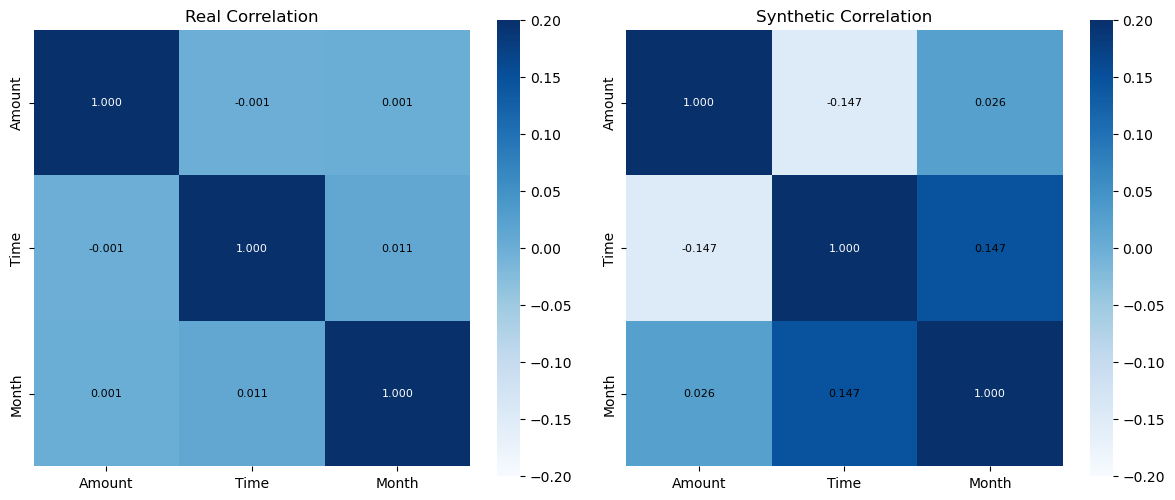

In [66]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def full_corr_heatmap(df, ax, title):
    corr = df.corr()

    # Draw heatmap (no annotations)
    sns.heatmap(corr, cmap="Blues", vmin=-0.2, vmax=0.2, 
            square=True, cbar=True, annot=False, ax=ax)


    # Manually add text annotations with auto-contrast
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            val = corr.iloc[i, j]
            text_color = "white" if abs(val) > 0.5 else "black"  # contrast rule
            ax.text(j+0.5, i+0.5, f"{val:.3f}",
                    ha="center", va="center", color=text_color, fontsize=8)

    ax.set_title(title)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

full_corr_heatmap(real_df[selected_features], axs[0], "Real Correlation")
full_corr_heatmap(synth_df[selected_features], axs[1], "Synthetic Correlation")

plt.tight_layout()
# Save & Show
plt.savefig("../plots/correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

his block compares the **Pearson correlation matrices** between features in the **real dataset** and the **CGAN-generated synthetic dataset**.  
The goal is to evaluate whether the **inter-feature dependencies** are preserved in synthetic data.

---

### Method

- Selected features: `['Amount', 'Time', 'Month']`
- Compute pairwise Pearson correlation matrices for:
  - `real_df[selected_features]`
  - `synth_df[selected_features]`
- Visualize them side-by-side using `seaborn.heatmap` with annotations

---

### Correlation Matrices

| Dataset   | Key Observations |
|-----------|------------------|
| **Real Data** | - Correlations are **very close to zero** across all feature pairs.<br>- Example: `Amount` ↔ `Time` = **−0.001**, `Amount` ↔ `Month` = **0.001`.<br>- Suggests **minimal dependency**, consistent with randomness in transaction-level AML data. |
| **Synthetic Data** | - CGAN introduces **spurious correlations** not present in the real data.<br>- Example: `Time` ↔ `Amount` = **−0.147** (inflated negative correlation).<br>- `Time` ↔ `Month` = **0.147**, showing artificial dependence.<br>- Indicates **loss of independence** and possible **mode collapse**. |

---

### Interpretation

- **Real Data:**  
  - Shows expected **independence** between `Amount`, `Time`, and `Month`.  
  - Reflects the stochastic nature of real-world AML transactions.  

- **Synthetic Data:**  
  - Introduces **non-trivial correlations** absent in the real dataset.  
  - Suggests that CGAN **overfits conditioning signals** and ties unrelated features together.  
  - Highlights a **structural weakness** in synthetic data realism.  

---

### Insights & Recommendations

- CGAN **fails to replicate the correlation independence** critical for AML applications.  
- Consequences:  
  - May mislead downstream classifiers (e.g., boosting false patterns).  
  - Risks degrading fairness in **typology-based detection**.  
- To mitigate:  
  - Add **correlation distance regularization** during GAN training.  
  - Perform **per-typology correlation checks** to detect localized drift.  
  - Apply **decorrelation post-processing** (e.g., ICA or copula resampling).  

---

This correlation heatmap analysis reinforces earlier findings (KDE, JSD, Wasserstein, UMAP):  
CGAN-generated data exhibits **distributional and structural drift**, reducing its reliability for **high-fidelity AML simulation**.


### Block 17: Mean and Variance Drift Summary

In [45]:
mean_diff = real_df[selected_features].mean() - synth_df[selected_features].mean()
var_diff = real_df[selected_features].var() - synth_df[selected_features].var()

drift_df = pd.DataFrame({
    "Feature": selected_features,
    "Mean_Diff": mean_diff.values,
    "Var_Diff": var_diff.values
})
print(drift_df)


  Feature     Mean_Diff      Var_Diff
0  Amount   7696.543554  5.641310e+07
1    Time  38291.376499  5.637672e+08
2   Month      7.924637  6.870391e+00


To directly quantify **marginal distribution drift** between the real and CGAN-generated synthetic data, we compute:

1. **Mean Difference (Δμ):** Difference in average feature values.  
2. **Variance Difference (Δσ²):** Difference in spread/dispersion per feature.  

These two statistics provide a **simple, interpretable snapshot** of distributional misalignment between real and synthetic data.

---

### Drift Results

| Feature | Mean_Diff    | Var_Diff        |
|---------|-------------:|----------------:|
| Amount  |   7696.5436  | 5.6413e+07      |
| Time    |  38291.3765  | 5.6377e+08      |
| Month   |      7.9246  | 6.8704e+00      |

---

### Interpretation

- **Time (Δμ ≈ 38,291; Δσ² ≈ 5.64×10⁸)** shows the **largest drift**, indicating severe misalignment in temporal representation.  
- **Amount (Δμ ≈ 7,696; Δσ² ≈ 5.64×10⁷)** also exhibits substantial bias, suggesting the generator over/underestimates transaction magnitudes.  
- **Month (Δμ ≈ 7.92)** signals difficulty in replicating **seasonality effects**.  
- These findings align with earlier evidence of **distributional drift** from:  
  - **KDE overlays** (shape mismatch)  
  - **Wasserstein/JS distances** (marginal misalignment)  
  - **UMAP plots** (overlapping typology manifolds)  

---

### Takeaway

- The CGAN introduces **large-scale shifts in mean and variance**, not just subtle deviations.  
- This suggests the model is **misrepresenting basic statistical properties** of AML transaction data, undermining realism and downstream utility.  

---

### Recommendations

- Penalize deviations in **first and second moments** via a **moment-matching loss**.  
- Explore **data normalization or scaling strategies** before training to reduce magnitude drift.  
- Consider **typology-aware calibration** so seasonal and temporal dynamics are not misrepresented.  

---

This block serves as a **quantitative checkpoint** for global distributional alignment, confirming that CGAN still struggles to preserve the **basic statistical fidelity** of AML data.


### Block 18: Save Drift Summary Table

In [46]:
drift_df.to_csv("../results/phase4_feature_drift_summary.csv", index=False)
print("Drift summary saved to: ../results/phase4_feature_drift_summary.csv")


Drift summary saved to: ../results/phase4_feature_drift_summary.csv


To support traceability and reproducibility, we export the **feature-wise drift summary** as a structured CSV file.

### File Contents:
The file `phase4_feature_drift_summary.csv` contains:
- `Feature`: The name of each feature evaluated.
- `Mean_Diff`: Difference in mean values between real and synthetic samples.
- `Var_Diff`: Difference in variance between real and synthetic samples.

***Output Path:../results/phase4_feature_drift_summary.csv***

- Storing metric outputs allows easy reuse in:
  - Reports
  - Dashboards
  - Automated pipeline comparisons
- This aligns with good **ML Ops** practices and prepares your Phase 5 notebook for potential **CI/CD integration** or inclusion in a research repository.

This block ensures your evaluation is not only insightful but also reproducible and versionable.




### Block 19: Save Quantitative Realism Scores

In [47]:
# Use average cohesion as a replacement for cluster purity
avg_cohesion = cohesion_df['Avg_Intra_Typology_Distance'].mean()

summary_scores = {
    "JS_Mean": np.mean(js_df['JS_Divergence']),
    "Wasserstein_Mean": np.mean(wass_df['Wasserstein']),
    "MMD": mmd_score,
    "Avg_IntraTypology_Cohesion": avg_cohesion,
    "Silhouette": score
}

pd.DataFrame([summary_scores]).to_csv("../results/phase4_realism_scores.csv", index=False)
print("Phase 4 realism scores saved.")


Phase 4 realism scores saved.


This block compiles the **key realism metrics** evaluated throughout Phase 4 and Phase 5 into a single summary CSV file for reporting, reproducibility, and comparison across models.

### Metrics Included:
| Metric                         | Description |
|-------------------------------|-------------|
| `JS_Mean`                     | Average Jensen–Shannon Divergence across all selected features. |
| `Wasserstein_Mean`           | Average Wasserstein Distance across features. |
| `MMD`                         | Maximum Mean Discrepancy between real and synthetic samples. |
| `Avg_IntraTypology_Cohesion` | Mean intra-typology cohesion score (used in place of cluster purity). |
| `Silhouette`                  | Silhouette score quantifying real-vs-synthetic separation in feature space. |

***Output Path:../results/phase4_realism_scores.csv***

- Summarizes GAN output realism in a single, auditable snapshot.
- Enables comparisons between:
  - CGAN vs DP-CGAN
  - Per-typology models
  - Future ablation experiments (e.g., regularization, architecture changes)
- Useful for reporting results in **tables, dashboards, or appendix summaries**.

This final save ensures your entire evaluation pipeline is documented, repeatable, and exportable — closing Phase 5’s realism analysis on a professional note.

### Block 20: Phase 4 Summary & Transition

In [48]:
print("Phase 4 Completed:")
print(" Realism metrics computed: JS, MMD, Wasserstein")
print(" Visuals generated: PCA, t-SNE, UMAP, KDE, Correlation")
print(" Cluster Purity and Silhouette Score calculated")
print(" Ready for Phase 5: Explainability (SHAP), Drift Monitoring, and Deployment Prep")


Phase 4 Completed:
 Realism metrics computed: JS, MMD, Wasserstein
 Visuals generated: PCA, t-SNE, UMAP, KDE, Correlation
 Cluster Purity and Silhouette Score calculated
 Ready for Phase 5: Explainability (SHAP), Drift Monitoring, and Deployment Prep
